In [1]:
import glob
import importlib
import os
import random
import sys
from itertools import combinations

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker
import pyemma

import extq
from extq import memory

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)
pplt.load_cmaps()

In [4]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True))
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# displacement charges
dq_trajs = list(np.load(f"{DATA_DIR}/raw_feat/displacement_q_0-178.npy"))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_179-end.npy", allow_pickle=True))
dq_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/displacement_q_anton2.npy"))
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8]  # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[
    8
]

# remove trajectory 180 (missing full data)
cv_trajs = [*cv_trajs[:180], *cv_trajs[181:]]
sb_trajs = [*sb_trajs[:180], *sb_trajs[181:]]
sb_arr = np.concatenate(sb_trajs)
cv_arr = np.concatenate(cv_trajs)
qp_du = [*qp_du[:180], *qp_du[181:]]
weights = [*weights[:180], *weights[181:]]

ivac_trajs = np.load(f"{DATA_DIR}/raw_feat/feat2_ivac_anton2_10-1000.npy", allow_pickle=True)
ivac_trajs = [*ivac_trajs[:180], *ivac_trajs[181:]]
ivac_arr = np.concatenate(ivac_trajs)

In [5]:
print(
    cv_arr.shape,
    sb_arr.shape,
    np.concatenate(qp_du).shape,
    np.concatenate(dq_trajs).shape,
)

(4050115, 2) (4050115, 60) (4050115,) (4050115,)


# Cluster

In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [7]:
def cluster(k):
    km_ivac = MiniBatchKMeans(n_clusters=k)
    km_ivac.fit(ivac_arr)

    centers = km_ivac.cluster_centers_
    neighbors = NearestNeighbors(n_neighbors=1)
    neighbors.fit(centers)

    dtrajs_ivac = neighbors.kneighbors(ivac_arr, return_distance=False)
    return dtrajs_ivac

In [8]:
def avg_cluster(dtraj, f):
    num = np.bincount(dtraj, weights=f)
    denom = np.bincount(dtraj)
    return num / denom

In [9]:
def transition_matrix(basis, weights, lag):
    c0 = 0.0
    ct = 0.0
    for x, w in zip(basis, weights):
        wx = extq.linalg.scale_rows(w[:-lag], x[:-lag])
        c0 += wx.T @ x[:-lag]
        ct += wx.T @ x[lag:]
    return extq.linalg.inv(c0) @ ct

In [14]:
def reweight_p0(p0, dq, voltage):
    reweighted = p0 * np.exp(voltage * dq * 0.03868) # voltage in mV
    reweighted /= np.sum(reweighted)
    return reweighted

## 200 clusters

In [10]:
dtrajs_200 = cluster(200)

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
cluster_dq_200= avg_cluster(dtrajs_200.squeeze(), np.concatenate(dq_trajs))

In [12]:
dq_sortids = np.argsort(cluster_dq_200)

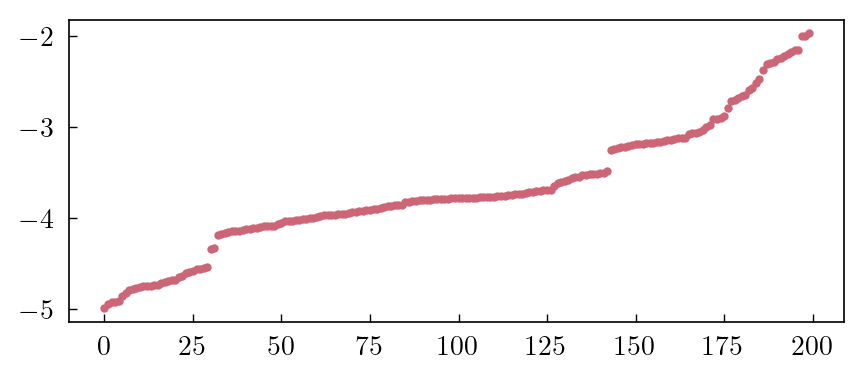

In [13]:
plt.figure(dpi=200, figsize=(5, 2))
plt.plot(np.arange(200), cluster_dq_200[np.argsort(cluster_dq_200)], 'o')

### Build MSM transition matrix

In [15]:
basis_arr = util.make_sparse_basis(np.squeeze(dtrajs_200))

traj_lens = [len(traj) for traj in cv_trajs]
basis = []
curr = 0
for t_len in traj_lens:
    basis.append(basis_arr[curr : curr + t_len])
    curr += t_len

### Test lag = 100 (10 ns)

In [41]:
T_lag100 = transition_matrix(basis, weights, 100)

In [42]:
msm_lag100 = pyemma.msm.MSM(T_lag100)

In [59]:
msm_lag100.timescales()

array([612.48765092, 121.61501074,  84.95984704,  72.32723462,
        70.46023209,  57.96934733,  39.81366178,  38.88577283,
        28.11848551])

In [43]:
p0 = msm_lag100.stationary_distribution
p0_m70 = reweight_p0(p0, cluster_dq_200, -70)

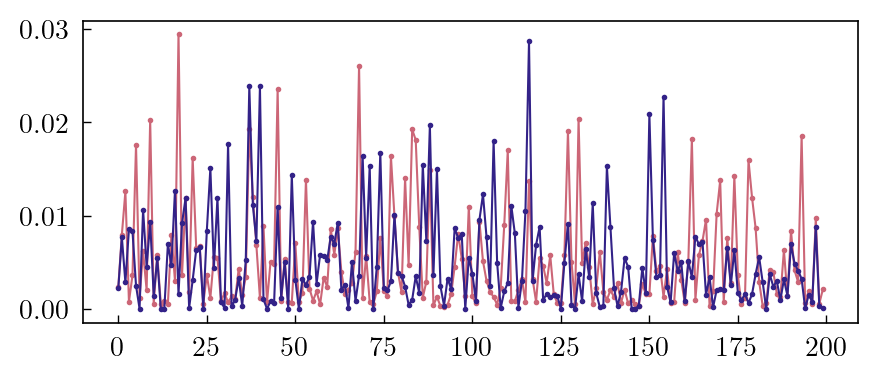

In [44]:
plt.figure(dpi=200, figsize=(5, 2))
plt.plot(p0, ".-")
plt.plot(p0_m70, ".-")

In [45]:
time, q_relax = msm_lag100.relaxation(p0_m70, cluster_dq_200, k=10)

Text(0, 0.5, '$Q_{\\rm d}$')

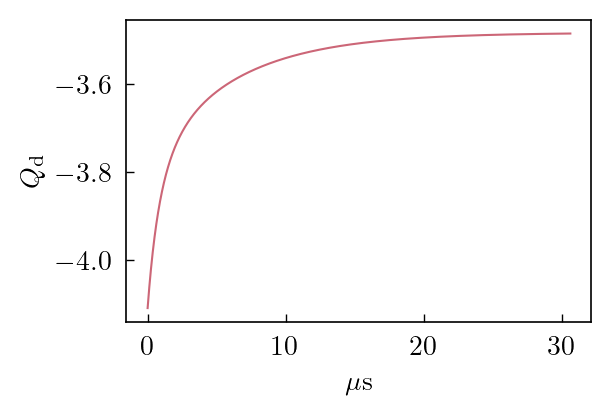

In [46]:
plt.figure(dpi=200, figsize=(3, 2))
plt.plot(time * 0.01, q_relax)
plt.xlabel("$\mu$s")
plt.ylabel(r"$Q_{\rm d}$")

Text(0, 0.5, '$I_{\\rm d}$')

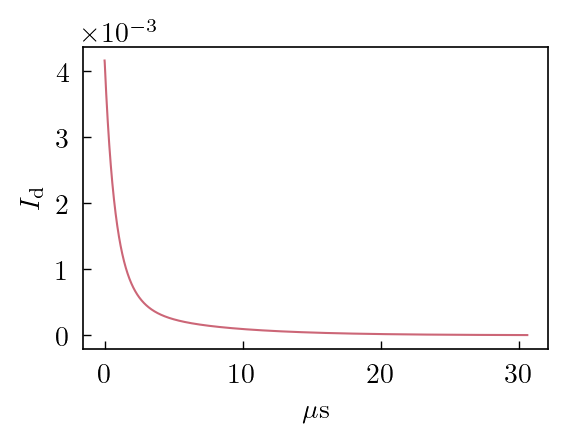

In [47]:
# plot time derivative (sensing current)
plt.figure(dpi=200, figsize=(3, 2))
plt.plot(time * 0.01, np.gradient(q_relax))
plt.xlabel("$\mu$s")
plt.ylabel(r"$I_{\rm d}$")

## lag 1000 (100 ns)

In [48]:
T_lag1000 = transition_matrix(basis, weights, 1000)

In [50]:
msm_lag1000 = pyemma.msm.MSM(T_lag1000)

In [51]:
p0 = msm_lag1000.stationary_distribution
p0_m70 = reweight_p0(p0, cluster_dq_200, -70)

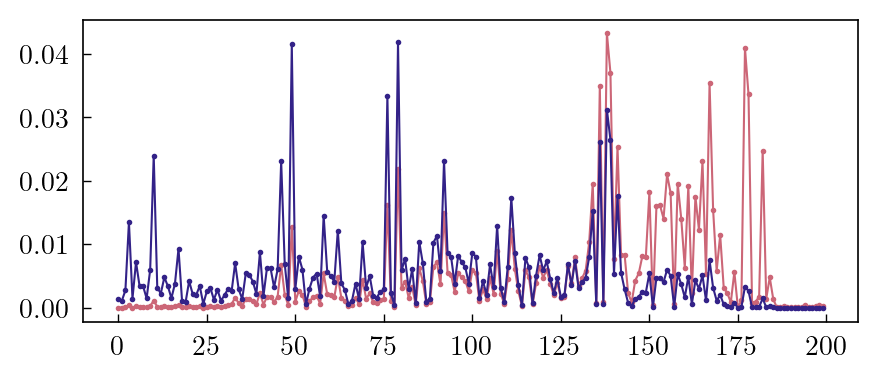

In [52]:
plt.figure(dpi=200, figsize=(5, 2))
plt.plot(p0[dq_sortids], ".-")
plt.plot(p0_m70[dq_sortids], ".-")

In [53]:
time, q_relax = msm_lag1000.relaxation(p0_m70, cluster_dq_200, k=10)

Text(0, 0.5, '$Q_{\\rm d}$')

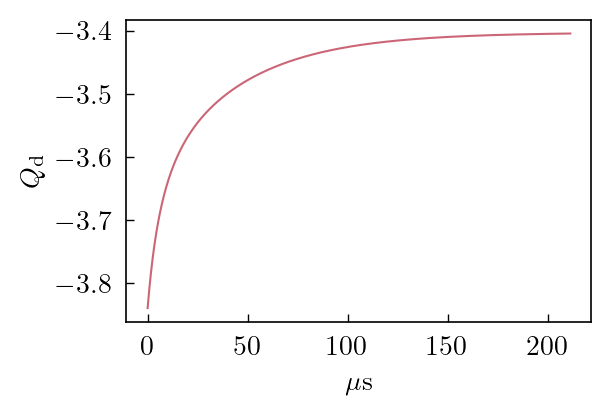

In [56]:
plt.figure(dpi=200, figsize=(3, 2))
plt.plot(time * 0.1, q_relax)
plt.xlabel("$\mu$s")
plt.ylabel(r"$Q_{\rm d}$")

Text(0, 0.5, '$I_{\\rm d}$')

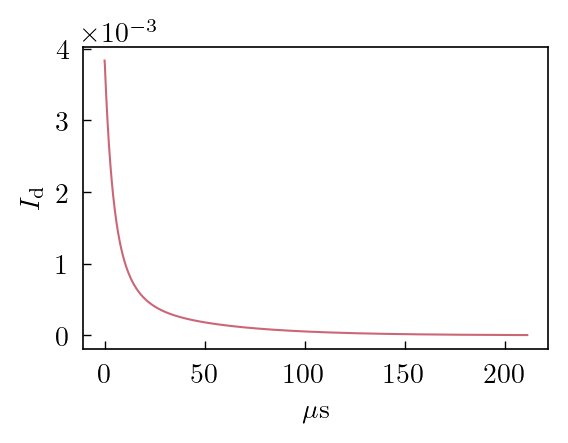

In [34]:
# plot time derivative (sensing current)
plt.figure(dpi=200, figsize=(3, 2))
plt.plot(time * 0.001, np.gradient(q_relax))
plt.xlabel("$\mu$s")
plt.ylabel(r"$I_{\rm d}$")

In [58]:
msm_lag1000.timescales()

array([422.65687096,  84.44676714,  53.11314663,  51.5127255 ,
        49.70654207,  34.49512646,  22.67535385,  21.1428382 ,
        19.2101504 ])

In [35]:
def model_func(params, t, y):
    return params[0] * np.exp(params[1] * t) + params[2] - y

def exp_fun(params, t):
    return params[0] * np.exp(params[1] * t) + params[2]

In [57]:
time

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 2.111e+03, 2.112e+03,
       2.113e+03])

In [36]:
x0 = (-1.0, -1.0, -1.0)
res_lsq = scipy.optimize.least_squares(model_func, x0, args=(time * 0., q_relax))

/scratch/local/jobs/5344163/ipykernel_2140629/1953720884.py:2: RuntimeWarning: overflow encountered in exp
  return params[0] * np.exp(params[1] * t) + params[2] - y


In [39]:
print(-1 / res_lsq.x[1])

280.9982432322965


## 500 clusters

In [61]:
dtrajs_500 = cluster(500)

/beagle3/dinner/scguo/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
cluster_dq_500 = avg_cluster(dtrajs_500.squeeze(), np.concatenate(dq_trajs))

In [63]:
dq_sortids = np.argsort(cluster_dq_500)

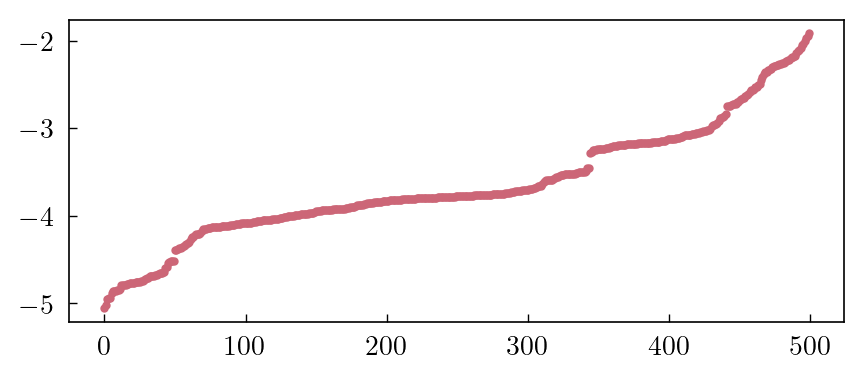

In [65]:
plt.figure(dpi=200, figsize=(5, 2))
plt.plot(np.arange(500), cluster_dq_500[dq_sortids], 'o')

In [66]:
basis_arr = util.make_sparse_basis(np.squeeze(dtrajs_500))

traj_lens = [len(traj) for traj in cv_trajs]
basis = []
curr = 0
for t_len in traj_lens:
    basis.append(basis_arr[curr : curr + t_len])
    curr += t_len

### Test lag = 100 (10 ns)

In [67]:
T_lag100 = transition_matrix(basis, weights, 100)

In [68]:
msm_lag100 = pyemma.msm.MSM(T_lag100)

In [69]:
msm_lag100.timescales()

array([903.96622496, 154.65631468, 126.18204721,  97.9711448 ,
        89.94765596,  76.57563435,  51.04687728,  46.83715949,
        33.6302282 ])

In [86]:
p0 = msm_lag100.stationary_distribution
p0_m70 = reweight_p0(p0, cluster_dq_500, -70)

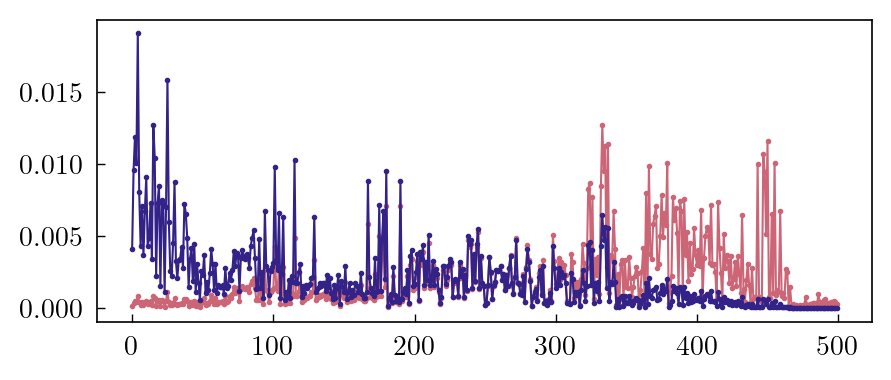

In [87]:
plt.figure(dpi=200, figsize=(5, 2))
plt.plot(p0[dq_sortids], ".-")
plt.plot(p0_m70[dq_sortids], ".-")

In [88]:
time, q_relax = msm_lag100.relaxation(p0_m70, cluster_dq_500, k=10)

Text(0, 0.5, '$Q_{\\rm d}$')

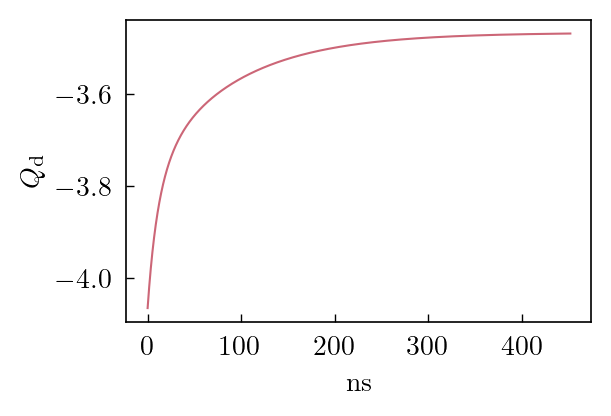

In [89]:
plt.figure(dpi=200, figsize=(3, 2))
plt.plot(time * 0.1, q_relax)
plt.xlabel("ns")
plt.ylabel(r"$Q_{\rm d}$")

In [84]:
x0 = (-1.0, -1.0, -1.0)
res_lsq = scipy.optimize.least_squares(model_func, x0, args=(time * 0.1, q_relax))

In [85]:
print(-1 / res_lsq.x[1])

43.203205152170746


# Simulation stochastic trajectories

In [54]:
def simulate_trajectories(ntraj, nsteps):
    ans = []
    for i in range(ntraj):
        ans.append(msm_lag100.simulate(nsteps))
    return np.array(ans)

In [55]:
ntraj = 1000
nsteps = 10000
msm_trajs = simulate_trajectories(ntraj, nsteps)

In [56]:
msm_trajs.shape

(1000, 10000)

In [61]:
q_ensemble_avg = np.mean(mean[msm_trajs], axis=0)
q_ensemble_std = np.std(mean[msm_trajs], axis=0)

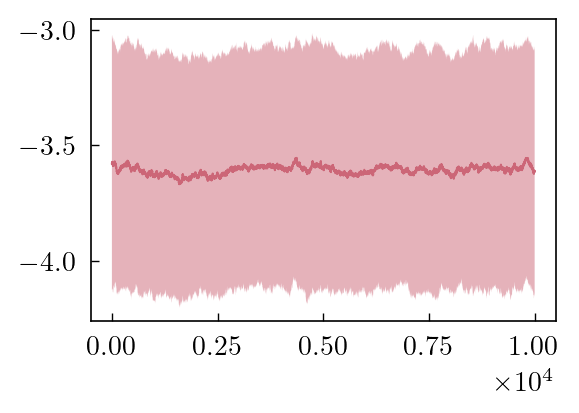

In [63]:
plt.figure(figsize=(3, 2), dpi=200)
plt.plot(q_ensemble_avg)
plt.fill_between(np.arange(nsteps), q_ensemble_avg - q_ensemble_std, q_ensemble_avg + q_ensemble_std, alpha=0.5)